# NEON

This notebook shows some data prep for NEON datasets...if you want to skip this, you can just download the 'subsets' data for the main tutorial.  To run this code, you'll first need to download and unpack the full dataset (https://avng.jpl.nasa.gov/pub/PBrodrick/isofit/tutorials/neon_full_data.zip).

In [6]:
# Jupyter magics
import matplotlib.pyplot as plt

# Setup logging
import logging
import os

from types import SimpleNamespace
import numpy as np


# Enable the ISOFIT logger
logging.getLogger().setLevel(logging.INFO)

# Find where we're running the tutorial from
home = os.path.abspath(os.getcwd())

# Path to the input NEON data
indata = os.path.join(home, 'data') 
subset_dir = os.path.join(indata, 'subsets')

# Path to write isofit output
output = os.path.join(home,'outputs')
if os.path.isdir(output) is False:
    os.mkdir(output)

if os.path.isdir(subset_dir) is False:
    os.mkdir(subset_dir)


%matplotlib inline

## Setup

ISOFIT needs at minimum three pieces as input:

    1. Radiance measurements (rdn)
    2. Observation values    (obs)
    3. Location information  (loc)

This sample dataset from NEON has radiance and observation data, but no location values (more recent NEON datasets include the location file).  However, we can 'fake' the location file with sufficient accuracy for ISOFIT to run successfully.  Note that there are data available for two dates:

```
Radiance
├── 173647
│   ├── NIS01_20210403_173647_obs_ort
│   ├── NIS01_20210403_173647_obs_ort.hdr
│   ├── NIS01_20210403_173647_rdn_ort
│   └── NIS01_20210403_173647_rdn_ort.hdr
└── 174150
    ├── NIS01_20210403_174150_obs_ort
    ├── NIS01_20210403_174150_obs_ort.hdr
    ├── NIS01_20210403_174150_rdn_ort
    └── NIS01_20210403_174150_rdn_ort.hdr
```

These files have corresponding in situ data as well, and below we've encoded the locations of each, which we can use to help subset data files.

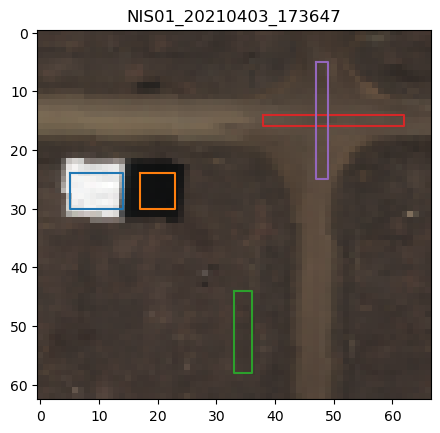

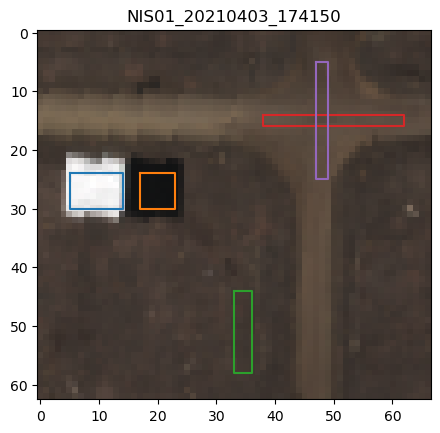

In [8]:
from spectral.io import envi
%matplotlib inline

offsets = {}
for key in report.keys():
    rdn = envi.open(os.path.join(indata,f'NIS01_20210403_{key}_rdn_ort.hdr')).open_memmap(interleave='bip')[:,:,np.array([60,40,30])].copy()

    miny = np.min([np.min([i[0],i[1]]) for k,i in report[key].items()])-5
    maxy = np.max([np.max([i[0],i[1]]) for k,i in report[key].items()])+5
    minx = np.min([np.min([i[2],i[3]]) for k,i in report[key].items()])-5
    maxx = np.max([np.max([i[2],i[3]]) for k,i in report[key].items()])+5
    offsets[key] = [minx,miny]

    plt.figure()
    plt.imshow(rdn[miny:maxy,minx:maxx,:] / np.max(rdn[miny:maxy,minx:maxx,:],axis=(0,1)))
    plt.title(f'NIS01_20210403_{key}')
    for k,i in report[key].items():
        plt.plot([i[2]-minx,i[3]-minx,i[3]-minx,i[2]-minx,i[2]-minx],[i[0]-miny,i[0]-miny,i[1]-miny,i[1]-miny,i[0]-miny],label=k)

    meta = envi.open(os.path.join(indata,f'NIS01_20210403_{key}_rdn_ort.hdr')).metadata
    meta['map info'][3] = str(float(meta['map info'][3]) + minx*float(meta['map info'][1]))
    meta['map info'][4] = str(float(meta['map info'][4]) - miny*float(meta['map info'][2]))
    meta['lines'] = maxy-miny
    meta['samples'] = maxx-minx
    out_ds = envi.create_image(os.path.join(subset_dir, f'NIS01_20210403_{key}_rdn_ort.hdr'), meta, ext="", force=True)
    out_ds.open_memmap(writable=True)[:,:,:] = envi.open(os.path.join(indata,f'NIS01_20210403_{key}_rdn_ort.hdr')).open_memmap(interleave='bip')[miny:maxy,minx:maxx,:].copy()
    del out_ds

    meta['band names'] = envi.open(os.path.join(indata,f'NIS01_20210403_{key}_rdn_obs_ort.hdr')).metadata['band names']
    obs = envi.open(os.path.join(indata,f'NIS01_20210403_{key}_rdn_obs_ort.hdr')).open_memmap(interleave='bip')[miny:maxy,minx:maxx,:].copy()
    meta['bands'] = obs.shape[-1]
    del meta['wavelength'] 
    del meta['fwhm'] 
    out_ds = envi.create_image(os.path.join(subset_dir, f'NIS01_20210403_{key}_rdn_obs_ort.hdr'), meta, ext="", force=True)
    out_ds.open_memmap(writable=True)[:,:,:] = obs
    del out_ds